In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from statsmodels.tsa.stattools import adfuller

In [26]:
pd.options.display.float_format = "{:,.5f}".format
np.set_printoptions(precision=3, suppress=True)

In [22]:
df = pd.read_csv('sales_train.csv')
test_df = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')
items = pd.read_csv('items.csv')
item_categories = pd.read_csv('item_categories.csv')
shops = pd.read_csv('shops.csv')

In [23]:
df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.00
1,03.01.2013,0,25,2552,899.00,1.00
2,05.01.2013,0,25,2552,899.00,-1.00
3,06.01.2013,0,25,2554,"1,709.05",1.00
4,15.01.2013,0,25,2555,"1,099.00",1.00


In [7]:
data = df.groupby(['shop_id', 'item_id', 'date_block_num'], as_index=False)\
    .agg({'item_cnt_day': 'sum'}).rename({'item_cnt_day': 'item_cnt_month'}, axis=1)

In [8]:
data.head()

,shop_id,item_id,date_block_num,item_cnt_month
0,0,30,1,31.00
1,0,31,1,11.00
2,0,32,0,6.00
3,0,32,1,10.00
4,0,33,0,3.00


In [9]:
shop_5_data = data[data.shop_id == 5]

In [10]:
shop_5_data

,shop_id,item_id,date_block_num,item_cnt_month
64224,5,27,7,1.00
64225,5,27,17,1.00
64226,5,29,6,1.00
64227,5,30,1,5.00
64228,5,30,2,7.00
...,...,...,...,...
88327,5,22164,33,1.00
88328,5,22167,12,1.00
88329,5,22167,15,1.00
88330,5,22167,18,1.00


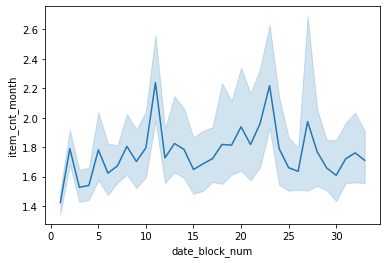

In [11]:
sns.lineplot(data=shop_5_data, x='date_block_num', y='item_cnt_month');

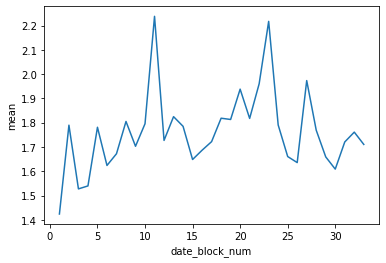

In [12]:
sns.lineplot(data=shop_5_data.groupby(['date_block_num'], as_index=False).agg({'item_cnt_month': 'mean'})\
             .rename({'item_cnt_month': 'mean'}, axis=1), x='date_block_num', y='mean');

In [14]:
def test_stationarity(timeseries, window=5):
    
    moving_average = timeseries.rolling(window).mean()
    moving_std = timeseries.rolling(window).std()
    
    print('Stationarity test results:')
    df_test = adfuller(timeseries, autolag='AIC')
    df_output = pd.Series(df_test[:4], index=['Test statistic', 'p-value', 
                                              '#Lags used', 'Number of observations used'])
    print(df_output)

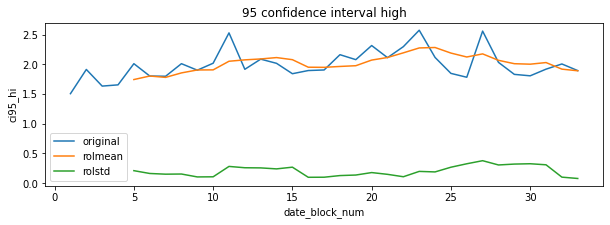

Stationarity test results:
Test statistic                -4.53022
p-value                        0.00017
#Lags used                     0.00000
Number of observations used   32.00000
dtype: float64


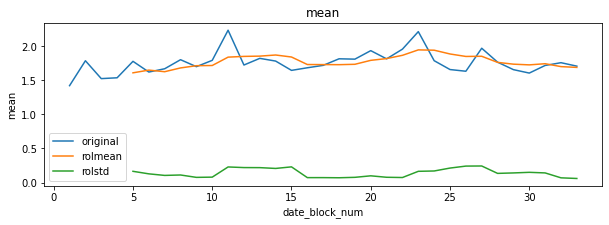

Stationarity test results:
Test statistic                -4.80225
p-value                        0.00005
#Lags used                     0.00000
Number of observations used   32.00000
dtype: float64


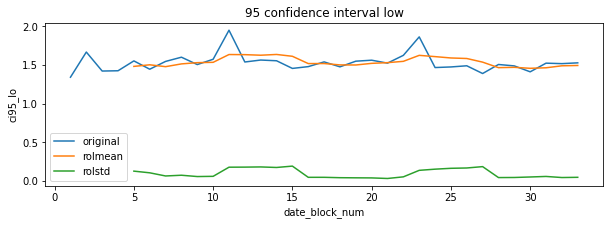

Stationarity test results:
Test statistic                -5.49705
p-value                        0.00000
#Lags used                     0.00000
Number of observations used   32.00000
dtype: float64


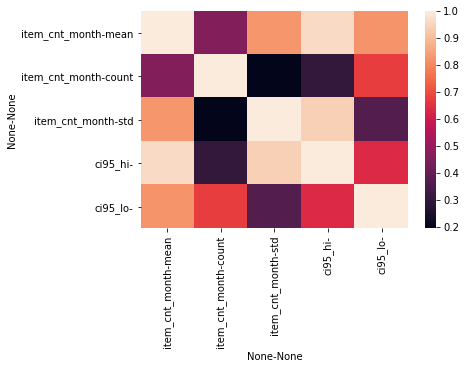

In [31]:
stats=shop_5_data.groupby(['date_block_num']).agg({'item_cnt_month': ['mean', 'count', 'std']})

ci95_hi = []
ci95_lo = []

for i in stats.index:
    m, c, s = stats.loc[i]
    ci95_hi.append(m + 1.95*s/math.sqrt(c))
    ci95_lo.append(m - 1.95*s/math.sqrt(c))

stats['ci95_hi'] = ci95_hi
stats['ci95_lo'] = ci95_lo

#stats.head()
plt.figure(figsize=(10, 3))
sns.lineplot(data=stats, x='date_block_num', y='ci95_hi', label='original');
rolmean = stats['ci95_hi'].rolling(window=5).mean()
rolstd = stats['ci95_hi'].rolling(window=5).std()
sns.lineplot(data=rolmean, label='rolmean')
sns.lineplot(data=rolstd, label='rolstd')
plt.title('95 confidence interval high')
plt.show()
test_stationarity(stats['ci95_hi'])

plt.figure(figsize=(10, 3))
sns.lineplot(data=stats, x='date_block_num', y=stats.item_cnt_month['mean'], label='original')
rolmean = stats['item_cnt_month']['mean'].rolling(window=5).mean()
rolstd = stats['item_cnt_month']['mean'].rolling(window=5).std()
sns.lineplot(data=rolmean, label='rolmean')
sns.lineplot(data=rolstd, label='rolstd')
plt.title('mean')
plt.show()
test_stationarity(stats['item_cnt_month']['mean'])

plt.figure(figsize=(10, 3))
sns.lineplot(data=stats, x='date_block_num', y='ci95_lo', label='original');
rolmean = stats['ci95_lo'].rolling(window=5).mean()
rolstd = stats['ci95_lo'].rolling(window=5).std()
sns.lineplot(data=rolmean, label='rolmean')
sns.lineplot(data=rolstd, label='rolstd')
plt.title('95 confidence interval low')
plt.show()
test_stationarity(stats['ci95_lo'])

sns.heatmap(stats.corr(), annot=T)
plt.show()